In [287]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.use('pdf')
import sys
sys.path.append("../")
import copy
from Plotting.generate_database import ResultsDatabaseGenerator
from common_packages.utilities import get_equivalent_classical_layer_size, get_num_parameters_per_quantum_layer
from Plotting.Plot import BasicPlot, MultiPlot
import pandas as pd
colors =   ["#5dd448",
            "#bfa900",
            "#ec742f",
            "#e9496f",
            "#b04ca4",]

colors = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.linewidth"] = 0.5

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [288]:
%matplotlib inline
ex_path = "Synthetic_Hybrid_PWB_Experiment"
dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[6]['config']
config.pop('__doc__', None)
df = pd.DataFrame(columns=config.keys())
df['avg_acc'] = np.nan
df['acc_err'] = np.nan
df['avg_loss'] = np.nan
df['loss_err'] = np.nan
for i in range(1, len(data) + 1):
    config = data[i]['config']
    config.pop('__doc__', None)
    metrics = data[i]['metrics']
    metrics.pop('epoch',None)
    acc, loss = metrics.values()
    avg_acc = np.mean(acc)
    acc_err = np.std(acc)
    avg_loss = np.mean(loss)
    loss_err = np.std(loss)
    df.loc[i] = [*config.values(), avg_acc, acc_err, avg_loss, loss_err]
   
    
df = df.sort_values('sigma')
x = np.array(df['sigma'].unique()).astype(float)
x = np.log2(1+1/x)
plot_df = pd.DataFrame(index=x)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,6), sharex=True, sharey=True)
fig.supxlabel('Precision (Bits)')
fig.suptitle('Synthetic Dataset Accuracy Comparison')
for i in range(2,5):

    mask = (df['network_type']=='quantum') & (df['num_qumodes']==i)

    x1 = np.array(df[mask]['sigma'].unique()).astype(float)
    x1 = np.log2(1+1/x1)

    acc_q = df[mask]['avg_acc']
    acc_err_q = df[mask]['acc_err']
    loss_q = df[mask]['avg_loss']
    loss_err_q = df[mask]['loss_err']

    mask = (df['network_type']=='classical') & (df['num_qumodes']==i)

    x2 = np.array(df[mask]['sigma'].unique()).astype(float)
    x2 = np.log2(1+1/x2)
    
    acc_c = df[mask]['avg_acc']
    acc_err_c = df[mask]['acc_err']
    loss_c = df[mask]['avg_loss']
    loss_err_c = df[mask]['loss_err']
    
    mask = (df['network_type']=='classical_tf') & (df['num_qumodes']==i)

    x3 = np.array(df[mask]['sigma'].unique()).astype(float)
    x3 = np.log2(1+1/x3)
    
    acc_tf = df[mask]['avg_acc']
    acc_err_tf = df[mask]['acc_err']
    loss_tf = df[mask]['avg_loss']
    loss_err_tf = df[mask]['loss_err']
    
    #ax[i-2].grid(True, linestyle=':')
    line_q = ax[i-2].plot(x1, acc_q, label='Hybrid', alpha=0.8)
    ax[i-2].fill_between(x1, acc_q - acc_err_q, acc_q + acc_err_q, interpolate=True, alpha=0.3)
    
    line_c = ax[i-2].plot(x2, acc_c, label='Classical', alpha=0.8)
    ax[i-2].fill_between(x2, acc_c - acc_err_c, acc_c + acc_err_c, interpolate=True, alpha=0.3)
    ax[i-2].set_title(f'{i} Qumode')
    
    line_tf = ax[i-2].plot(x3, acc_tf, label='TF', alpha=0.8)
    ax[i-2].fill_between(x3, acc_tf - acc_err_tf, acc_tf + acc_err_tf, interpolate=True, alpha=0.3)
    ax[i-2].hlines([0.9,0.9], 1, 10, color=colors[5], linestyles='--')
    
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=5)
plt.savefig('../MidWinter/Synthetic_comparison.pdf')

FileNotFoundError: [Errno 2] No such file or directory: 'Synthetic_Hybrid_PWB_Experiment'

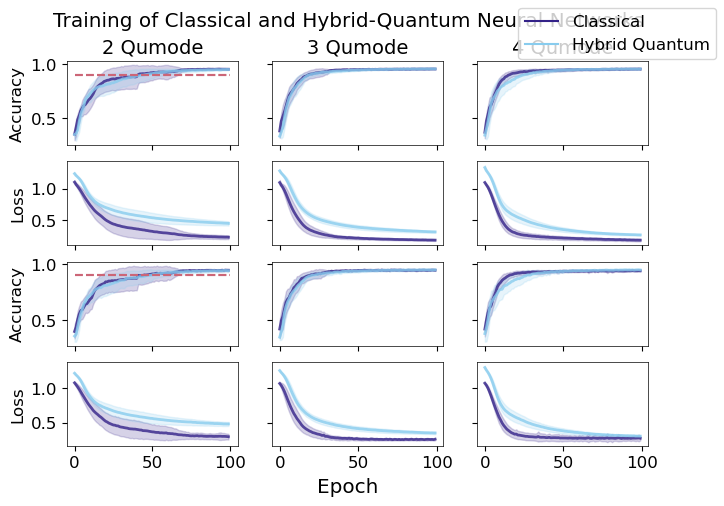

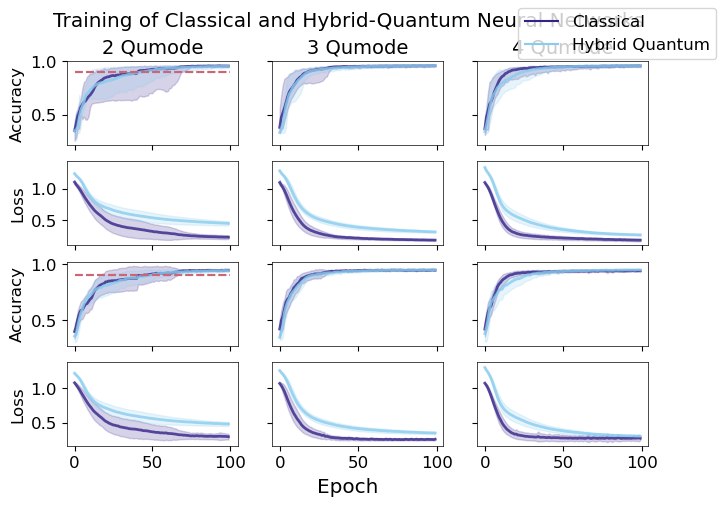

In [289]:
ex_path = "Synthetic_Hybrid_Base_Experiment_100Epochs_2"
dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[1]['config']
config.pop('__doc__', None)
#config.pop('iteration', None)
df = pd.DataFrame(columns=config.keys())
df['acc'] = np.nan
df['val_acc'] = np.nan
df['loss'] = np.nan
df['val_loss'] = np.nan
for i in range(1, len(data) + 1):
    try:
        config = data[i]['config']
        config.pop('__doc__', None)
        #config.pop('iteration', None)
        metrics = data[i]['metrics']
        metrics.pop('epoch',None)
        acc, loss, val_acc, val_loss = metrics.values()
        acc = np.array(acc)
        assert acc.shape[-1] == 100
        loss = np.array(loss)
        val_acc = np.array(val_acc)
        val_loss = np.array(val_loss)
        df.loc[i] = [*config.values(), acc, val_acc, loss, val_loss]
    except (KeyError, AssertionError):
        print(f"Invalid: {i}")
#df = df.explode(column=['acc', 'val_acc', 'loss', 'val_loss'])
df_mean =df.groupby(['network_type', 'num_qumodes']).apply(lambda x: pd.DataFrame({
    'acc': [np.mean(x['acc'].tolist(), axis=0)],
    'val_acc': [np.mean(x['val_acc'].tolist(), axis=0)],
    'loss': [np.mean(x['loss'].tolist(), axis=0)],
    'val_loss': [np.mean(x['val_loss'].tolist(), axis=0)]
}))
df_mean.reset_index()
"""df_std = df.groupby(['network_type', 'num_qumodes']).apply(
    lambda x: x[['acc','val_acc', 'loss', 'val_loss']].apply(
        lambda y: np.std(y)).rename(columns={
            'acc' : 'acc_std','val_acc':'val_acc_std', 'loss':'loss_std', 'val_loss':'val_loss_std'}))
"""
df_std =df.groupby(['network_type', 'num_qumodes']).apply(lambda x: pd.DataFrame({
    'acc': [np.std(x['acc'].tolist(), axis=0)],
    'val_acc': [np.std(x['val_acc'].tolist(), axis=0)],
    'loss': [np.std(x['loss'].tolist(), axis=0)],
    'val_loss': [np.std(x['val_loss'].tolist(), axis=0)]
}))
df_std.reset_index()

df_min =df.groupby(['network_type', 'num_qumodes']).apply(lambda x: pd.DataFrame({
    'acc': [np.min(x['acc'].tolist(), axis=0)],
    'val_acc': [np.min(x['val_acc'].tolist(), axis=0)],
    'loss': [np.min(x['loss'].tolist(), axis=0)],
    'val_loss': [np.min(x['val_loss'].tolist(), axis=0)]
}))
df_min.reset_index()
df_max =df.groupby(['network_type', 'num_qumodes']).apply(lambda x: pd.DataFrame({
    'acc': [np.max(x['acc'].tolist(), axis=0)],
    'val_acc': [np.max(x['val_acc'].tolist(), axis=0)],
    'loss': [np.max(x['loss'].tolist(), axis=0)],
    'val_loss': [np.max(x['val_loss'].tolist(), axis=0)]
}))
df_max.reset_index()
#df_std.pop(column=3)
#display(df[(df['network_type'] == 'classical') & (df['num_qumodes']==2)])
#fig, ax = plt.subplots(figsize=(8,6))

names = [f'Classical: {get_equivalent_classical_layer_size(i, 2*i, 3)*2*i + 3} parameters' for i in range(2, 5)] \
    + [f'Quantum: {int(get_num_parameters_per_quantum_layer(i))} parameters' for i in range(2, 5)]

q_or_c = ['Classical' for i in range(3)] + ['Quantum' for i in range(3)]
fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(7.5, 5), sharey='row', sharex='col')
for i, (mean, std) in enumerate(zip(df_mean['acc'], df_std['acc'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[0,i%3].plot(x, y, lw=2, color=colors[i//3], alpha=0.8, )
    ax[0,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

for i, (mean, std) in enumerate(zip(df_mean['loss'], df_std['loss'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[1,i%3].plot(x, y, lw=2, alpha=0.8, color=colors[i//3], )
    ax[1,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

for i, (mean, std) in enumerate(zip(df_mean['val_acc'], df_std['val_acc'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[2,i%3].plot(x, y, lw=2, color=colors[i//3], alpha=0.8, )
    ax[2,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

for i, (mean, std) in enumerate(zip(df_mean['val_loss'], df_std['val_loss'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[3,i%3].plot(x, y, lw=2, alpha=0.8, color=colors[i//3], )
    ax[3,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

fig.supxlabel('Epoch')
for j,i in enumerate(ax[0]):
    i.set_title(f'{j+2} Qumode', fontsize=14)
ax[0,0].hlines([0.9, 0.9], xmin=0, xmax=100, color=colors[6], linestyles='--')
ax[2,0].hlines([0.9, 0.9], xmin=0, xmax=100, color=colors[6], linestyles='--')
ax[0,0].set_ylabel('Accuracy')
ax[1,0].set_ylabel('Loss')
ax[2,0].set_ylabel('Accuracy')
ax[3,0].set_ylabel('Loss')
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.suptitle('Training of Classical and Hybrid-Quantum Neural Networks')
plt.savefig('HybridTraining.pdf')
plt.show()

fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(7.5, 5), sharey='row', sharex='col')
for i, (mean, accmin, accmax) in enumerate(zip(df_mean['acc'], df_min['acc'], df_max['acc'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[0,i%3].plot(x, y, lw=2, color=colors[i//3], alpha=0.8, )
    ax[0,i%3].fill_between(x, accmin, accmax, color=colors[i//3], alpha=0.2)

for i, (mean, std) in enumerate(zip(df_mean['loss'], df_std['loss'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[1,i%3].plot(x, y, lw=2, alpha=0.8, color=colors[i//3], )
    ax[1,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

for i, (mean, std) in enumerate(zip(df_mean['val_acc'], df_std['val_acc'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[2,i%3].plot(x, y, lw=2, color=colors[i//3], alpha=0.8, )
    ax[2,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

for i, (mean, std) in enumerate(zip(df_mean['val_loss'], df_std['val_loss'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[3,i%3].plot(x, y, lw=2, alpha=0.8, color=colors[i//3], )
    ax[3,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

fig.supxlabel('Epoch')
for j,i in enumerate(ax[0]):
    i.set_title(f'{j+2} Qumode', fontsize=14)
ax[0,0].hlines([0.9, 0.9], xmin=0, xmax=100, color=colors[6], linestyles='--')
ax[2,0].hlines([0.9, 0.9], xmin=0, xmax=100, color=colors[6], linestyles='--')
ax[0,0].set_ylabel('Accuracy')
ax[1,0].set_ylabel('Loss')
ax[2,0].set_ylabel('Accuracy')
ax[3,0].set_ylabel('Loss')
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.suptitle('Training of Classical and Hybrid-Quantum Neural Networks')
plt.savefig('HybridTraining.pdf')
plt.show()




Inconsistent config parameter val_accuracy!=num_params found in experiment folder between file and reference 27. Ignoring experiment...
Inconsistent config parameter val_accuracy!=num_params found in experiment folder between file and reference 26. Ignoring experiment...


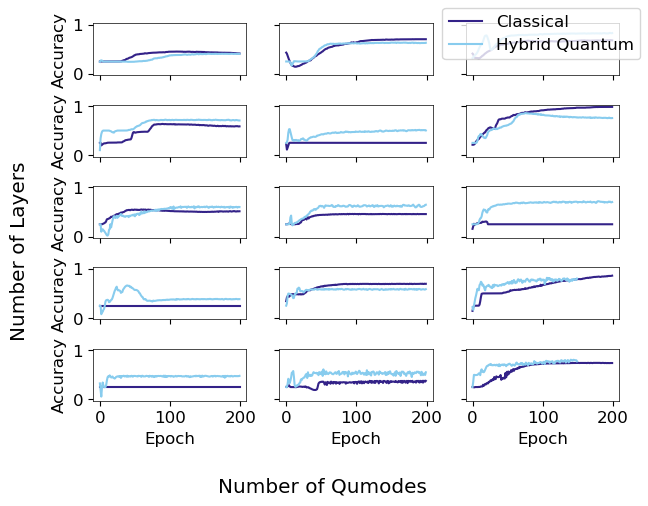

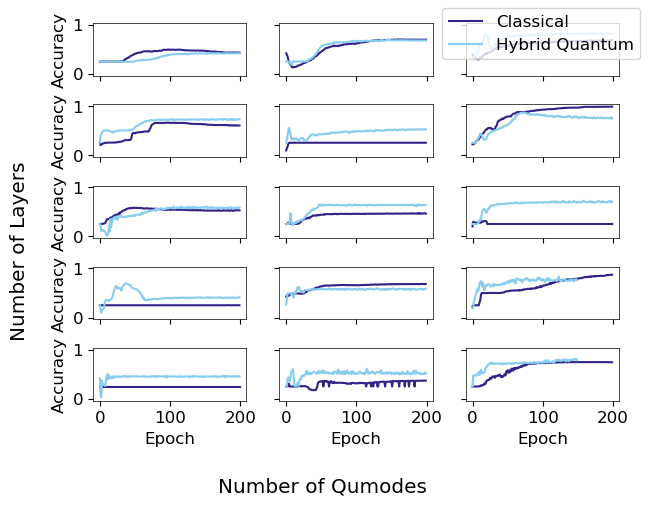

In [290]:
%matplotlib inline
ex_path = "./Synthetic_Quantum_Base_Experiment2"
dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[1]['config']
config.pop('__doc__', None)
#config.pop('iteration', None)
df = pd.DataFrame(columns=config.keys())
df['num_params'] = np.nan
df['acc'] = np.nan
df['val_acc'] = np.nan
df['loss'] = np.nan
df['val_loss'] = np.nan
for i in data.keys():
    config = data[i]['config']
    config.pop('__doc__', None)
    metrics = data[i]['metrics']
    metrics.pop('epoch',None)
    acc, loss, num_params, val_acc, val_loss = metrics.values()
    acc = np.array(acc)
    loss = np.array(loss)
    val_acc = np.array(val_acc)
    val_loss = np.array(val_loss)
    df.loc[i] = [*config.values(), num_params[0], acc, val_acc, loss, val_loss]
        
df.sort_values('network_type',inplace=True)
fig, ax = plt.subplots(nrows=df['n_layers'].max(), ncols=df['num_qumodes'].max()-1, figsize=(6.5,5), sharex=True, sharey=True)
for i, row in df.iterrows():
    vals = row['acc']
    idx_row = row['n_layers'] - 1
    idx_col = row['num_qumodes'] - 2
    ax[idx_row, idx_col].plot(vals)
    ax[-1,idx_col].set_xlabel('Epoch')
    ax[idx_row,0].set_ylabel('Accuracy')
fig.supylabel('Number of Layers')
fig.supxlabel('Number of Qumodes')
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.tight_layout()
plt.savefig('Training_Nlayers.png')

plt.show()
fig, ax = plt.subplots(nrows=df['n_layers'].max(), ncols=df['num_qumodes'].max()-1, figsize=(6.5,5), sharex=True, sharey=True)
for i, row in df.iterrows():
    vals = row['val_acc']
    idx_row = row['n_layers'] - 1
    idx_col = row['num_qumodes'] - 2
    ax[idx_row, idx_col].plot(vals)
    ax[-1,idx_col].set_xlabel('Epoch')
    ax[idx_row,0].set_ylabel('Accuracy')
fig.supylabel('Number of Layers')
fig.supxlabel('Number of Qumodes')
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.tight_layout()
plt.savefig('Validation_Nlayers.png')
plt.show()

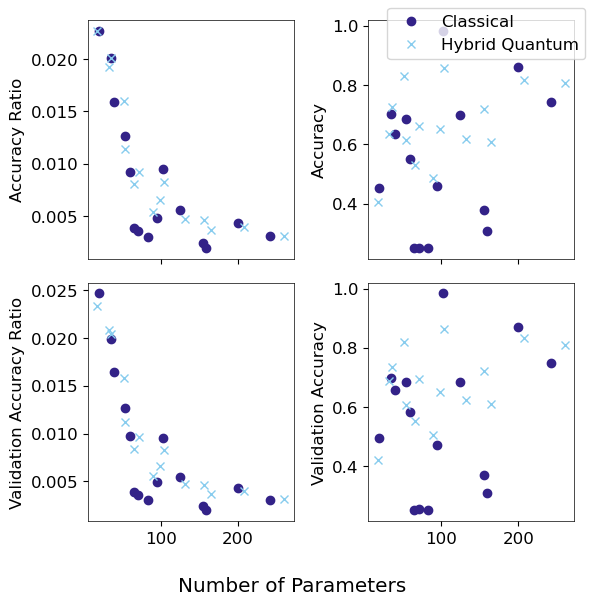

In [291]:
#display(df)
df_max = copy.deepcopy(df)
#display(df_max['acc'])
df_max['acc'] = df_max['acc'].apply(lambda x: np.max(x))
df_max['val_acc'] = df_max['val_acc'].apply(lambda x: np.max(x))
df_max['loss'] = df_max['loss'].apply(lambda x: np.max(x))
df_max['val_loss'] = df_max['val_loss'].apply(lambda x: np.max(x))
df_max['acc_ratio'] = df_max['acc']/df_max['num_params']
df_max['val_acc_ratio'] = df_max['val_acc']/df_max['num_params']

df_classical = df_max[df_max['network_type']=='classical']
df_quantum = df_max[df_max['network_type']=='quantum']

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6,6), sharex=True)

x,y = df_classical['num_params'], df_classical['acc_ratio']
axs[0,0].plot(x,y, 'o', color=colors[0])
axs[0,0].set_ylabel('Accuracy Ratio')

x,y = df_quantum['num_params'], df_quantum['acc_ratio']
axs[0,0].plot(x,y, 'x', color=colors[1])

x,y = df_classical['num_params'], df_classical['val_acc_ratio']
axs[1,0].plot(x,y, 'o', color=colors[0])
axs[1,0].set_ylabel('Validation Accuracy Ratio')

x,y = df_quantum['num_params'], df_quantum['val_acc_ratio']
axs[1,0].plot(x,y, 'x', color=colors[1])

x,y = df_classical['num_params'], df_classical['acc']
axs[0,1].plot(x,y, 'o', color=colors[0])
axs[0,1].set_ylabel('Accuracy')

x,y = df_quantum['num_params'], df_quantum['acc']
axs[0,1].plot(x,y, 'x', color=colors[1])

x,y = df_classical['num_params'], df_classical['val_acc']
axs[1,1].plot(x,y, 'o', color=colors[0])
axs[1,1].set_ylabel('Validation Accuracy')

x,y = df_quantum['num_params'], df_quantum['val_acc']
axs[1,1].plot(x,y, 'x', color=colors[1])
fig.supxlabel('Number of Parameters')
plt.plot([], 'o', color=colors[0], label='Classical')
plt.plot([], 'x', color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.tight_layout()

plt.savefig('AccPerParam.png')

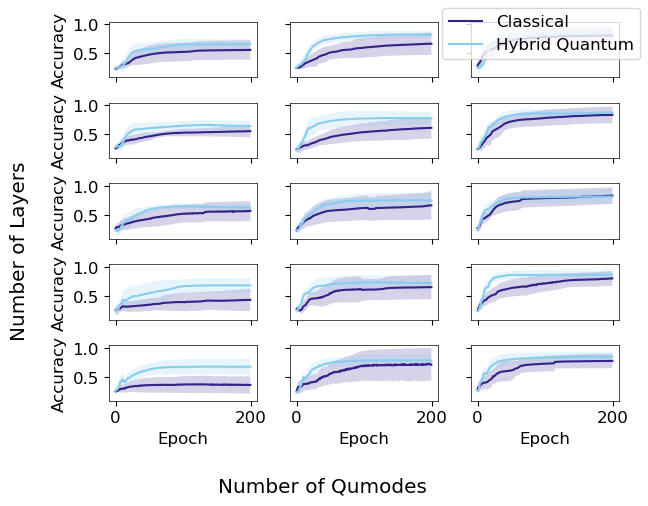

In [292]:
%matplotlib inline
ex_path = "./Synthetic_Quantum_Base_Experiment3"
dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[1]['config']
config.pop('__doc__', None)
#config.pop('iteration', None)
df = pd.DataFrame(columns=config.keys())
df['num_params'] = np.nan
df['acc'] = np.nan
df['val_acc'] = np.nan
df['loss'] = np.nan
df['val_loss'] = np.nan
for i in data.keys():
    config = data[i]['config']
    config.pop('__doc__', None)
    if config['iteration'] != -1:
        metrics = data[i]['metrics']
        metrics.pop('epoch',None)
        acc, loss, num_params, val_acc, val_loss = metrics.values()
        acc = np.array(acc)
        loss = np.array(loss)
        val_acc = np.array(val_acc)
        val_loss = np.array(val_loss)
        df.loc[i] = [*config.values(), num_params[0], acc, val_acc, loss, val_loss]

df_mean = df.groupby(['network_type', 'n_layers', 'num_qumodes', 'num_params']).apply(lambda x: pd.DataFrame({
    'acc': [np.mean(x['acc'].tolist(), axis=0)],
    'val_acc': [np.mean(x['val_acc'].tolist(), axis=0)],
    'loss': [np.mean(x['loss'].tolist(), axis=0)],
    'val_loss': [np.mean(x['val_loss'].tolist(), axis=0)]
}))
df_std =df.groupby(['network_type', 'n_layers', 'num_qumodes', 'num_params']).apply(lambda x: pd.DataFrame({
    'acc_std': [np.std(x['acc'].tolist(), axis=0)],
    'val_acc_std': [np.std(x['val_acc'].tolist(), axis=0)],
    'loss_std': [np.std(x['loss'].tolist(), axis=0)],
    'val_loss_std': [np.std(x['val_loss'].tolist(), axis=0)]
}))

df_max = df.groupby(['network_type', 'n_layers', 'num_qumodes', 'num_params']).apply(lambda x: pd.DataFrame({
    'acc_max': [np.max(x['acc'].tolist(), axis=0)],
    'val_acc_max': [np.max(x['val_acc'].tolist(), axis=0)],
    'loss_max': [np.max(x['loss'].tolist(), axis=0)],
    'val_loss_max': [np.max(x['val_loss'].tolist(), axis=0)]
}))

df_min = df.groupby(['network_type', 'n_layers', 'num_qumodes', 'num_params']).apply(lambda x: pd.DataFrame({
    'acc_min': [np.min(x['acc'].tolist(), axis=0)],
    'val_acc_min': [np.min(x['val_acc'].tolist(), axis=0)],
    'loss_min': [np.min(x['loss'].tolist(), axis=0)],
    'val_loss_min': [np.min(x['val_loss'].tolist(), axis=0)]
}))

df = pd.concat([df_mean, df_std, df_min, df_max], axis=1)
df.reset_index(inplace=True)
df.drop(columns='level_4', inplace=True)
df.sort_values('network_type',inplace=True)
fig, ax = plt.subplots(nrows=df['n_layers'].max(), ncols=df['num_qumodes'].max()-1, figsize=(6.5,5), sharex=True, sharey=True)
for i,row in df.iterrows():
    vals = row['acc']
    idx_row = row['n_layers'] - 1
    idx_col = row['num_qumodes'] - 2
    ax[idx_row, idx_col].plot(vals)
    ax[idx_row, idx_col].fill_between([i for i in range(len(vals))], row['acc'] - row['acc_std'], row['acc'] + row['acc_std'], alpha=0.2) 
    ax[-1,idx_col].set_xlabel('Epoch')
    ax[idx_row,0].set_ylabel('Accuracy')
    
fig.supylabel('Number of Layers')
fig.supxlabel('Number of Qumodes')
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.tight_layout()

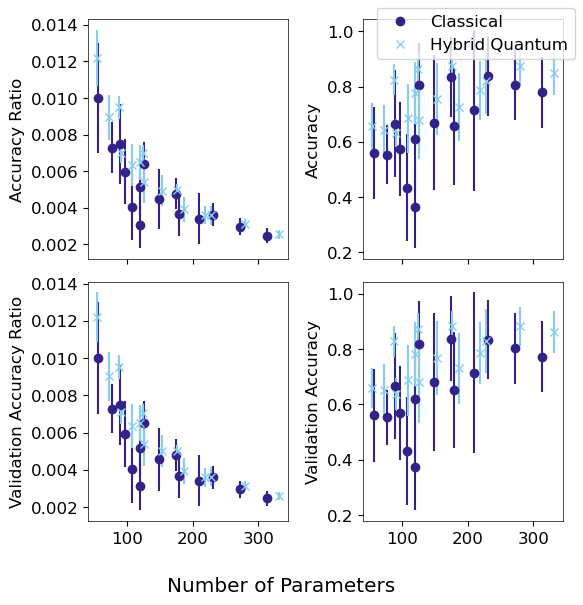

In [293]:
df_mean = copy.deepcopy(df)
df_mean['acc'] = df_mean['acc'].apply(lambda x: x[-1])
df_mean['acc_std'] = df_mean['acc_std'].apply(lambda x: x[-1])
df_mean['val_acc'] = df_mean['val_acc'].apply(lambda x: x[-1])
df_mean['val_acc_std'] = df_mean['val_acc_std'].apply(lambda x: x[-1])
df_mean['loss'] = df_mean['loss'].apply(lambda x: x[-1])
df_mean['loss_std'] = df_mean['loss_std'].apply(lambda x: x[-1])
df_mean['val_loss'] = df_mean['val_loss'].apply(lambda x: x[-1])
df_mean['val_loss_std'] = df_mean['val_loss_std'].apply(lambda x: x[-1])
df_mean['acc_ratio'] = df_mean['acc']/df_mean['num_params']
df_mean['acc_ratio_std'] = df_mean['acc_std']/df_mean['num_params']
df_mean['val_acc_ratio'] = df_mean['val_acc']/df_mean['num_params']
df_mean['val_acc_ratio_std'] = df_mean['val_acc_std']/df_mean['num_params']
df_classical = df_mean[df_mean['network_type']=='classical']
df_quantum = df_mean[df_mean['network_type']=='quantum']
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6,6), sharex=True)

x,y = df_classical['num_params'], df_classical['acc_ratio']
axs[0,0].errorbar(x,y, yerr=df_classical['acc_ratio_std'], fmt='o',ecolor=colors[0], color=colors[0])
axs[0,0].set_ylabel('Accuracy Ratio')

x,y = df_quantum['num_params'], df_quantum['acc_ratio']
axs[0,0].errorbar(x,y,  yerr=df_quantum['acc_ratio_std'], fmt='x', color=colors[1])

x,y = df_classical['num_params'], df_classical['val_acc_ratio']
axs[1,0].errorbar(x,y, yerr=df_classical['val_acc_ratio_std'], fmt='o', color=colors[0])
axs[1,0].set_ylabel('Validation Accuracy Ratio')

x,y = df_quantum['num_params'], df_quantum['val_acc_ratio']
axs[1,0].errorbar(x,y, yerr=df_quantum['val_acc_ratio_std'], fmt='x', ecolor=colors[1], color=colors[1])

x,y = df_classical['num_params'], df_classical['acc']
axs[0,1].errorbar(x,y, yerr=df_classical['acc_std'], fmt='o', color=colors[0])
axs[0,1].set_ylabel('Accuracy')

x,y = df_quantum['num_params'], df_quantum['acc']
axs[0,1].errorbar(x,y, yerr=df_quantum['acc_std'], fmt='x', color=colors[1])

x,y = df_classical['num_params'], df_classical['val_acc']
axs[1,1].errorbar(x,y, yerr=df_classical['val_acc_std'], fmt='o', color=colors[0])
axs[1,1].set_ylabel('Validation Accuracy')

x,y = df_quantum['num_params'], df_quantum['val_acc']
axs[1,1].errorbar(x,y, yerr=df_quantum['val_acc_std'], fmt='x', color=colors[1])
fig.supxlabel('Number of Parameters')
plt.errorbar([], [], fmt='o', ecolor=colors[0], color=colors[0], label='Classical')
plt.errorbar([], [], fmt='x', color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.tight_layout()

In [294]:
ex_path = "/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment_cutoff_sweep"
ex_path_kerr = "/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Kerr"

def generate_database(ex_path):
    dbGen = ResultsDatabaseGenerator()
    dbGen.initialize_from_folder(ex_path)
    data = dbGen.data
    config = data[1]['config']
    config.pop('__doc__', None)
    #config.pop('iteration', None)
    df = pd.DataFrame(columns=config.keys())
    df['num_params'] = np.nan
    df['acc'] = np.nan
    df['val_acc'] = np.nan
    df['loss'] = np.nan
    df['val_loss'] = np.nan
    for i in data.keys():
        config = data[i]['config']
        config.pop('__doc__', None)
        if config['iteration'] != -1:
            metrics = data[i]['metrics']
            metrics.pop('epoch',None)
            acc, loss, num_params, val_acc, val_loss = metrics.values()
            acc = np.array(acc)
            loss = np.array(loss)
            val_acc = np.array(val_acc)
            val_loss = np.array(val_loss)
            df.loc[i] = [*config.values(), num_params[0], acc, val_acc, loss, val_loss]
    return df


df_orig = generate_database(ex_path)
df_kerr = generate_database(ex_path_kerr)
display(df_orig.head())
display(df_kerr.head())

df_kerr.drop(df_kerr.loc[(df_kerr['network_type']=='classical') & (df_kerr['num_qumodes']==4)].index, inplace=True)

Exception Expecting value: line 1 column 1 (char 0)
Error reading from metrics file /home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment_cutoff_sweep/747 . Ignoring file...
Exception Expecting value: line 1 column 1 (char 0)
Error reading from metrics file /home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment_cutoff_sweep/735 . Ignoring file...
Inconsistent config parameter val_accuracy!=num_params found in experiment folder between file and reference 573. Ignoring experiment...
Inconsistent config parameter val_accuracy!=num_params found in experiment folder between file and reference 700. Ignoring experiment...
Inconsistent config parameter val_accuracy!=num_params found in experiment folder between file and reference 703. Ignoring experiment...
Inconsistent config parameter val_accuracy!=num_params found in experiment folder between file and reference 568. Ignoring experiment...
Inconsistent config parameter val_accuracy!=num_params found

,cutoff,iteration,n_layers,network_type,num_qumodes,num_params,acc,val_acc,loss,val_loss
49,8,1,3,quantum,3,153,"[0.2514285743236542, 0.3028571307659149, 0.372...","[0.25333333015441895, 0.33666667342185974, 0.3...","[1.7625699043273926, 1.742352843284607, 1.7216...","[1.7520743608474731, 1.7313326597213745, 1.711..."
181,1,3,1,quantum,2,54,"[0.24857142567634583, 0.24857142567634583, 0.2...","[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
363,1,8,3,classical,3,149,"[0.25999999046325684, 0.26428571343421936, 0.2...","[0.27666667103767395, 0.2666666805744171, 0.25...","[1.3936223983764648, 1.3882509469985962, 1.376...","[1.3927116394042969, 1.383899211883545, 1.3684..."
242,5,3,4,quantum,3,186,"[0.2514285743236542, 0.334285706281662, 0.4185...","[0.273333340883255, 0.38999998569488525, 0.439...","[1.6779426336288452, 1.6477246284484863, 1.618...","[1.660223126411438, 1.6304699182510376, 1.6020..."
52,9,1,3,quantum,2,90,"[0.24857142567634583, 0.2785714268684387, 0.30...","[0.24666666984558105, 0.3466666638851166, 0.30...","[1.6535885334014893, 1.6384344100952148, 1.623...","[1.6428987979888916, 1.6279345750808716, 1.613..."


,cutoff,iteration,n_layers,network_type,num_qumodes,num_params,acc,val_acc,loss,val_loss
49,5,5,1,quantum,2,190,"[0.20714285969734192, 0.23571428656578064, 0.2...","[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2...","[1.5348541736602783, 1.530426025390625, 1.5260...","[1.5323748588562012, 1.5279744863510132, 1.523..."
181,classical,5,2,classical,2,221,"[0.25, 0.25, 0.2571428716182709, 0.32714286446...","[0.25, 0.25, 0.2800000011920929, 0.35333332419...","[1.4020166397094727, 1.3867017030715942, 1.375...","[1.3958840370178223, 1.3823498487472534, 1.371..."
242,classical,9,2,classical,4,459,"[0.27000001072883606, 0.3471428453922272, 0.35...","[0.33666667342185974, 0.36666667461395264, 0.3...","[1.3915773630142212, 1.377332329750061, 1.3696...","[1.3854659795761108, 1.380081295967102, 1.3719..."
52,10,5,1,quantum,3,289,"[0.24714285135269165, 0.25999999046325684, 0.2...","[0.2266666740179062, 0.2199999988079071, 0.256...","[1.7590668201446533, 1.7476123571395874, 1.733...","[1.7544431686401367, 1.743351697921753, 1.7306..."
27,10,3,1,quantum,2,190,"[0.21142856776714325, 0.22142857313156128, 0.2...","[0.18000000715255737, 0.25333333015441895, 0.2...","[1.6455639600753784, 1.6410499811172485, 1.636...","[1.6430045366287231, 1.6385931968688965, 1.634..."


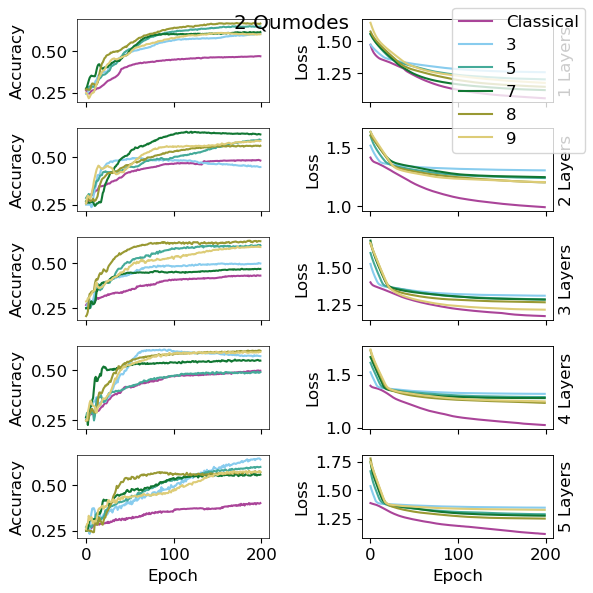

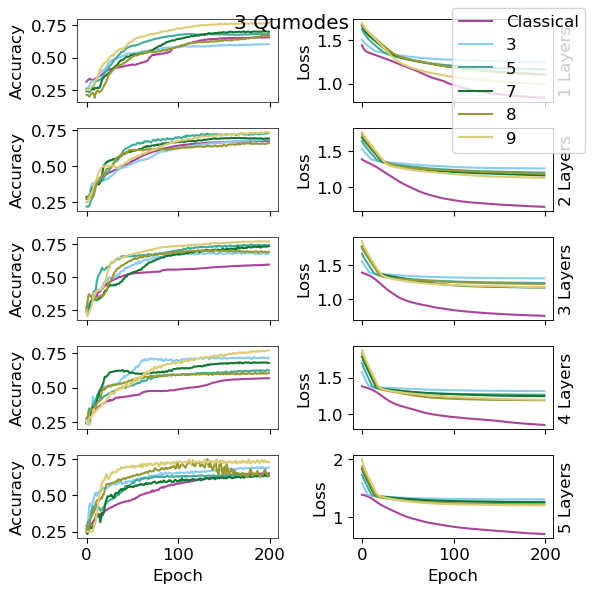

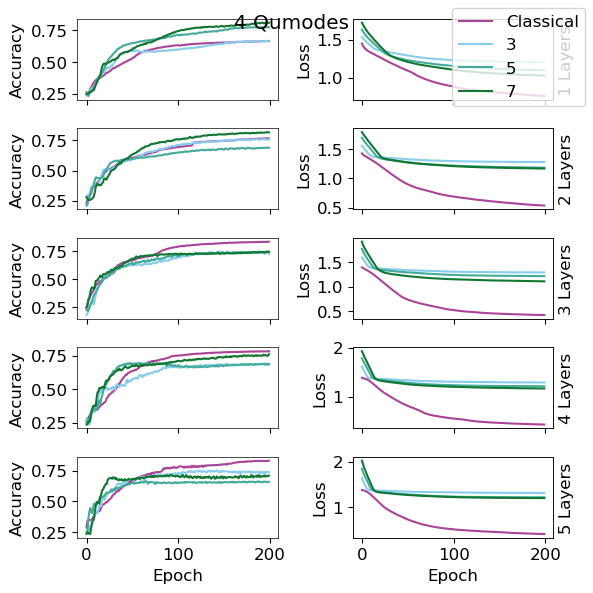

Kerr Encoding


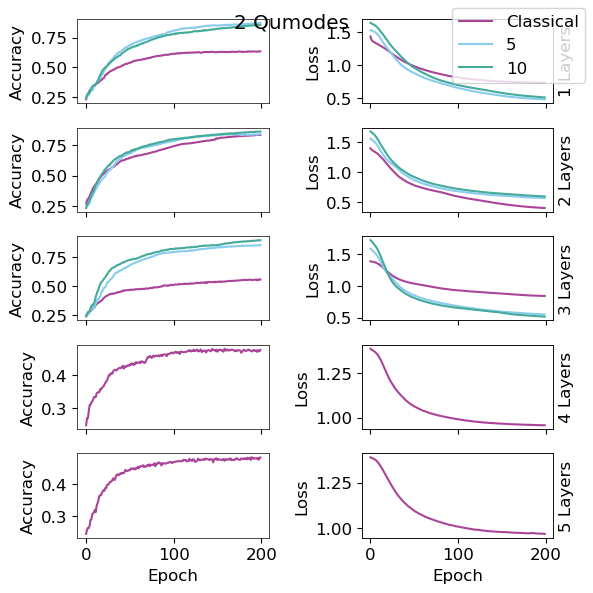

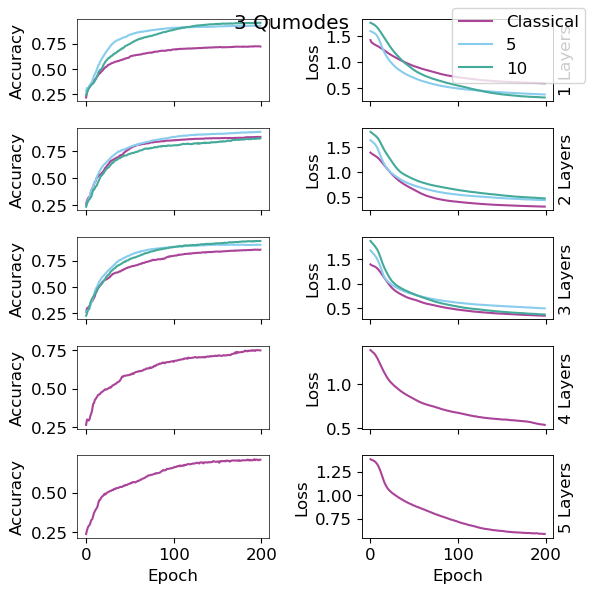

In [295]:
df_orig.loc[df_orig['network_type']=='classical', 'cutoff'] = 'classical'
df_orig.drop(df_orig[df_orig['cutoff']==1].index, inplace=True)
def process_data(df):
    df_mean = df.groupby(['network_type', 'n_layers', 'num_qumodes', 'num_params', 'cutoff']).apply(lambda x: pd.DataFrame({
        'acc': [np.mean(x['acc'].tolist(), axis=0)],
        'val_acc': [np.mean(x['val_acc'].tolist(), axis=0)],
        'loss': [np.mean(x['loss'].tolist(), axis=0)],
        'val_loss': [np.mean(x['val_loss'].tolist(), axis=0)]
    }))

    df_std = df.groupby(['network_type', 'n_layers', 'num_qumodes', 'num_params', 'cutoff']).apply(lambda x: pd.DataFrame({
        'acc_std': [np.std(x['acc'].tolist(), axis=0)],
        'val_acc_std': [np.std(x['val_acc'].tolist(), axis=0)],
        'loss_std': [np.std(x['loss'].tolist(), axis=0)],
        'val_loss_std': [np.std(x['val_loss'].tolist(), axis=0)]
    }))
    df_max = df.groupby(['network_type', 'n_layers', 'num_qumodes', 'num_params', 'cutoff']).apply(lambda x: pd.DataFrame({
        'acc_max': [np.max(x['acc'].tolist(), axis=0)],
        'val_acc_max': [np.max(x['val_acc'].tolist(), axis=0)],
        'loss_min': [np.min(x['loss'].tolist(), axis=0)],
        'val_loss_min': [np.min(x['val_loss'].tolist(), axis=0)]
    }))
    df_out = pd.concat([df_mean, df_std, df_max], axis=1)
    df_out.reset_index(inplace=True)
    df_out.drop(columns='level_5', inplace=True)
    df_out.sort_values(['network_type', 'num_qumodes', 'n_layers'],inplace=True)
    return df_out
df_o = process_data(df_orig)
df_k = process_data(df_kerr)

def plot_training_cutoff_sweep(df, fname='cutoff_sweep'):

    for n in df['num_qumodes'].unique():
        fig, axs = plt.subplots(ncols=2, nrows=len(df['n_layers'].unique()), figsize=(6,6), sharex=True)
        color_dict = dict(zip(df[df['num_qumodes']==n]['cutoff'].unique(), colors))
        color_dict['classical'] = colors[-1]
        for i in df['n_layers'].unique():
            ax2  = axs[i-1,1].twinx()
            ax2.set_yticks([])
            ax2.set_yticklabels([])
            ax2.set_ylabel(f'{i} Layers')
        
        for i, row in df[df['num_qumodes']==n].iterrows():
            idx_row = row['n_layers'] - 1
            epochs = [i for i in range(len(row['acc']))]
            axs[idx_row, 0].plot(epochs, row['acc'], color=color_dict[row['cutoff']])
            axs[idx_row, 1].plot(epochs, row['loss'], color=color_dict[row['cutoff']])
            
            axs[-1,0].set_xlabel('Epoch')
            axs[-1,1].set_xlabel('Epoch')
            axs[idx_row,0].set_ylabel('Accuracy')
            axs[idx_row,1].set_ylabel('Loss')

        for key,val in color_dict.items():
            plt.plot([], [], color=val, label=f'{key}'.capitalize())

        fig.legend()
        fig.tight_layout()
        fig.suptitle(f'{n} Qumodes')
        plt.savefig(f'./cutoff_sweep_plots/{fname}_{n}qumodes.png', dpi=300)
        plt.show()

plot_training_cutoff_sweep(df_o, 'cutoff_sweep')
print('Kerr Encoding')
plot_training_cutoff_sweep(df_k, 'cutoff_sweep_kerr')


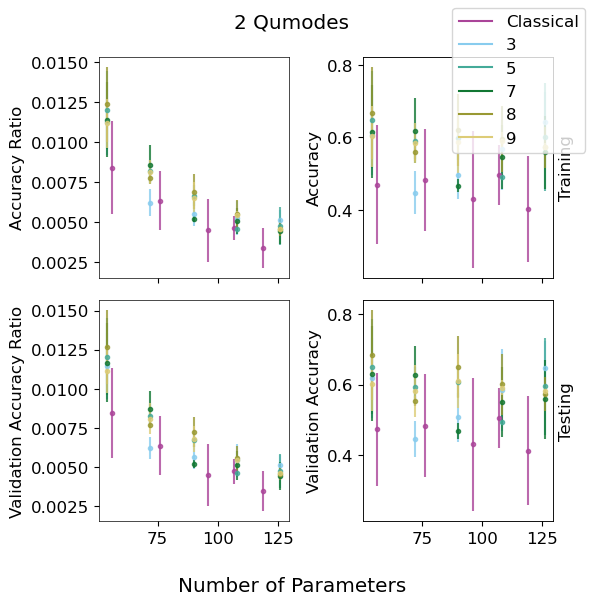

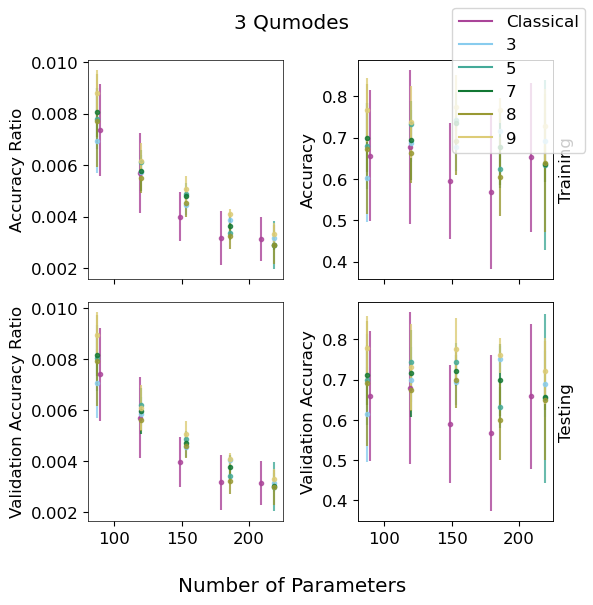

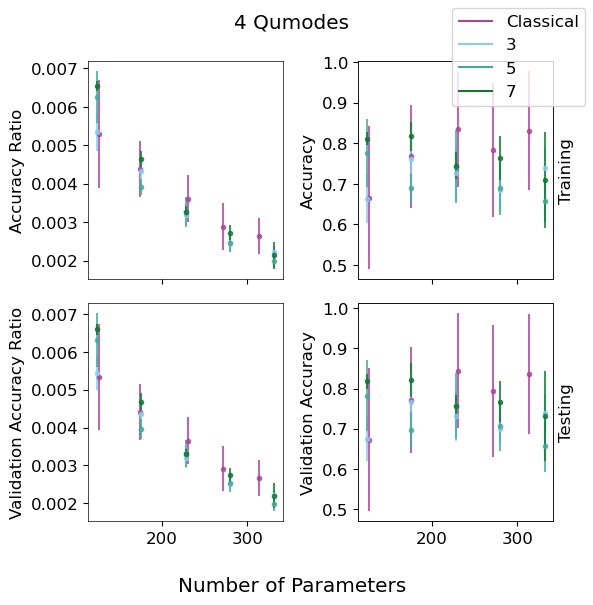

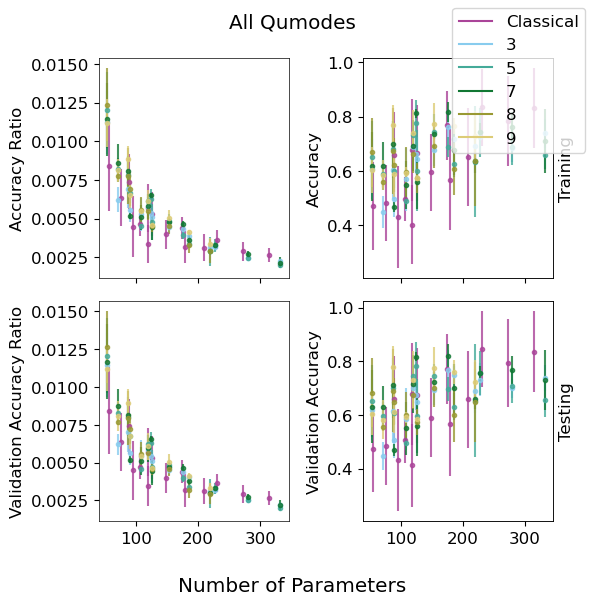

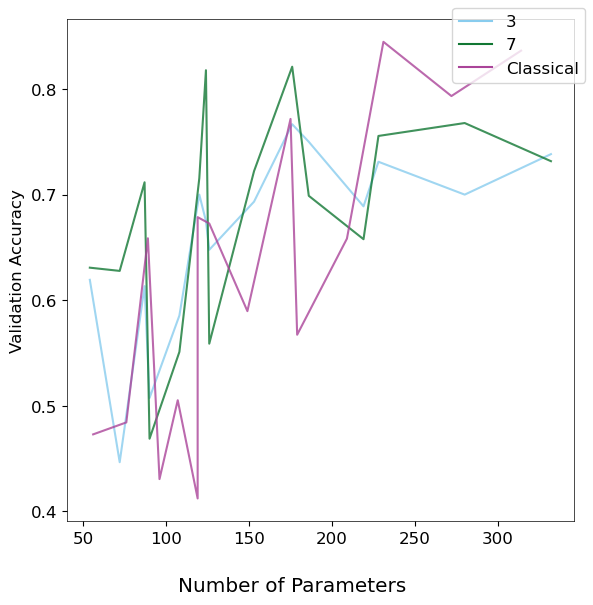

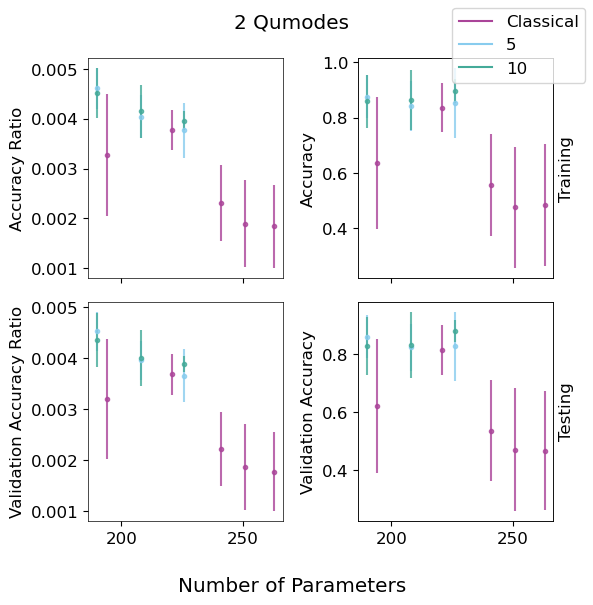

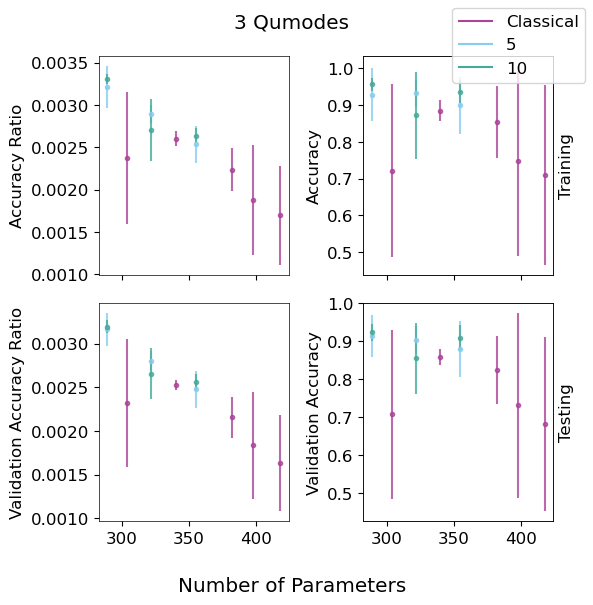

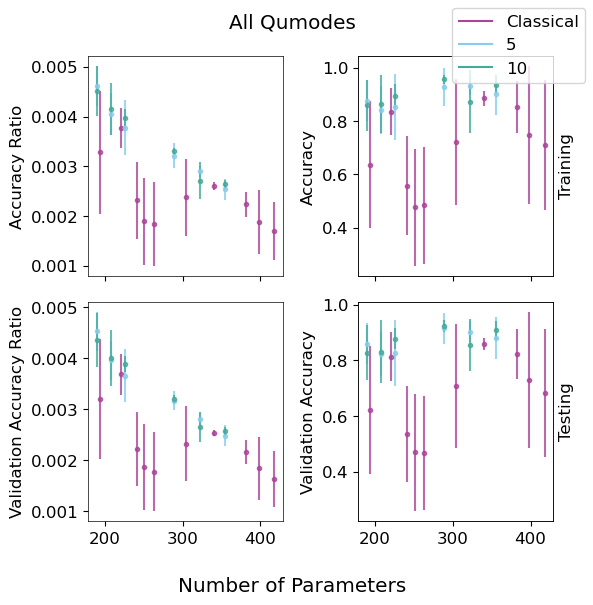

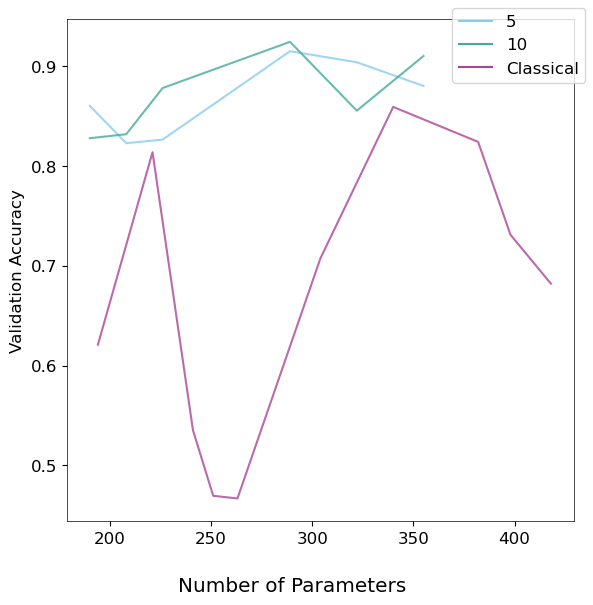

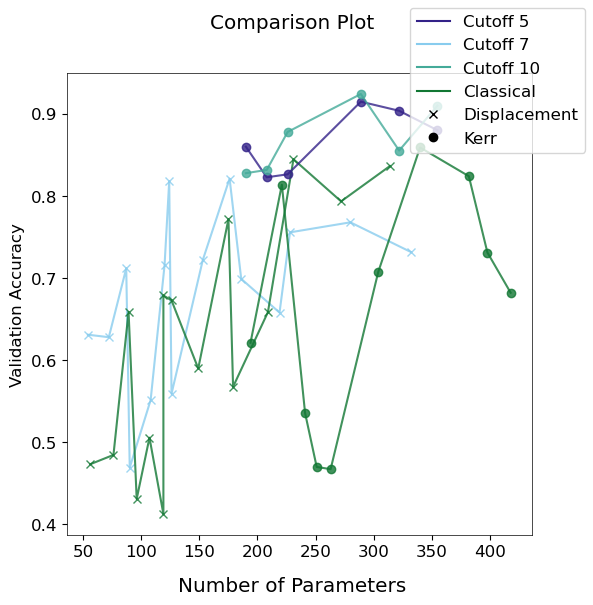

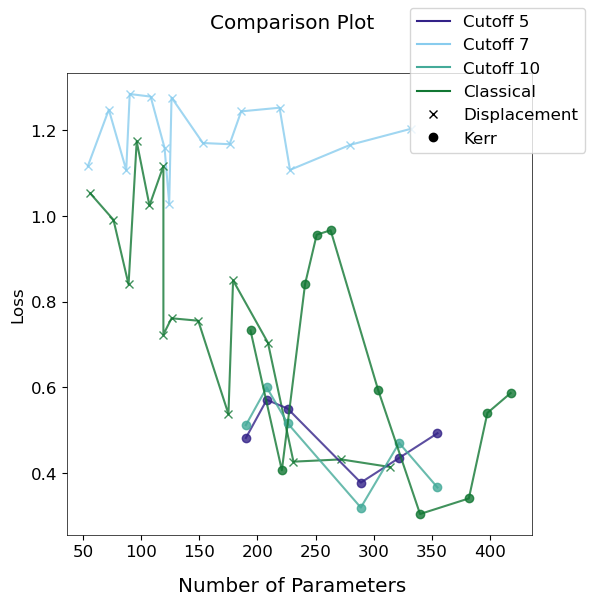

In [299]:

def generate_averaged_database(df):
    df_mean = copy.deepcopy(df)
    df_mean['acc'] = df_mean['acc'].apply(lambda x: x[-1])
    df_mean['acc_std'] = df_mean['acc_std'].apply(lambda x: x[-1])
    df_mean['val_acc'] = df_mean['val_acc'].apply(lambda x: x[-1])
    df_mean['val_acc_std'] = df_mean['val_acc_std'].apply(lambda x: x[-1])
    df_mean['loss'] = df_mean['loss'].apply(lambda x: x[-1])
    df_mean['loss_std'] = df_mean['loss_std'].apply(lambda x: x[-1])
    df_mean['val_loss'] = df_mean['val_loss'].apply(lambda x: x[-1])
    df_mean['val_loss_std'] = df_mean['val_loss_std'].apply(lambda x: x[-1])
    df_mean['acc_ratio'] = df_mean['acc']/df_mean['num_params']
    df_mean['acc_ratio_std'] = df_mean['acc_std']/df_mean['num_params']
    df_mean['val_acc_ratio'] = df_mean['val_acc']/df_mean['num_params']
    df_mean['val_acc_ratio_std'] = df_mean['val_acc_std']/df_mean['num_params']
    df_mean.sort_values('num_params')
    return df_mean

def plot_acc_per_param(df, fname='AccPerParam', cutoffs=[3,7,'classical']):
    color_dict = dict(zip(df['cutoff'].unique(), colors))
    color_dict['classical'] = colors[-1]
    for n in df['num_qumodes'].unique():
        color_dict = dict(zip(df[df['num_qumodes']==n]['cutoff'].unique(), colors))
        color_dict['classical'] = colors[-1]
        fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6,6), sharex=True)
        axs_dict = dict(zip(['acc_ratio', 'acc', 'val_acc_ratio', 'val_acc'], axs.flatten()))
        for cutoff in df[df['num_qumodes']==n]['cutoff'].unique():
            row = df.loc[(df['num_qumodes']==n) & (df['cutoff']==cutoff)]
            for metric in ['acc_ratio', 'val_acc_ratio', 'acc', 'val_acc']:
                axs_dict[metric].errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
                #axs_dict[metric].plot(row['num_params'].values, row[metric].values, '-', color=color_dict[cutoff], alpha=0.8)


        for key,val in color_dict.items():
            plt.plot([], [], color=val, label=f'{key}'.capitalize())

        ax2  = axs[0,1].twinx()
        ax2.set_yticks([])
        ax2.set_yticklabels([])
        ax2.set_ylabel(f'Training') 
    
        ax2  = axs[1,1].twinx()
        ax2.set_yticks([])
        ax2.set_yticklabels([])
        ax2.set_ylabel(f'Testing')   

        fig.legend()
        fig.supxlabel('Number of Parameters')
        fig.suptitle(f'{n} Qumodes')
        axs[0,0].set_ylabel('Accuracy Ratio')
        axs[1,0].set_ylabel('Validation Accuracy Ratio')
        axs[0,1].set_ylabel('Accuracy')
        axs[1,1].set_ylabel('Validation Accuracy')
        fig.tight_layout()
        plt.savefig(f'cutoff_sweep_plots/{fname}_AccPerParam_{n}qumodes.png', dpi=300)
        plt.show()


    color_dict = dict(zip(df['cutoff'].unique(), colors))
    color_dict['classical'] = colors[-1]
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6,6), sharex=True)
    axs_dict = dict(zip(['acc_ratio', 'acc', 'val_acc_ratio', 'val_acc'], axs.flatten()))
    for cutoff in df['cutoff'].unique():
            row = copy.deepcopy(df[(df['cutoff']==cutoff)])
            row.sort_values('num_params', inplace=True)
            for metric in ['acc_ratio', 'val_acc_ratio', 'acc', 'val_acc']:
                axs_dict[metric].errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
                #axs_dict[metric].plot(row['num_params'].values, row[metric].values, '-', color=color_dict[cutoff], alpha=0.8)

    for key,val in color_dict.items():
        plt.plot([], [], color=val, label=f'{key}'.capitalize())

    ax2  = axs[0,1].twinx()
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    ax2.set_ylabel(f'Training') 

    ax2  = axs[1,1].twinx()
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    ax2.set_ylabel(f'Testing')   

    fig.legend()
    fig.supxlabel('Number of Parameters')
    fig.suptitle(f'All Qumodes')
    axs[0,0].set_ylabel('Accuracy Ratio')
    axs[1,0].set_ylabel('Validation Accuracy Ratio')
    axs[0,1].set_ylabel('Accuracy')
    axs[1,1].set_ylabel('Validation Accuracy')
    fig.tight_layout()
    plt.savefig(f'cutoff_sweep_plots/{fname}_AccPerParam_allqumodes.png', dpi=300)
    plt.show()
    
    
    fig, axs = plt.subplots(figsize=(6,6), sharex=True)
    metric = 'val_acc'
    for cutoff in cutoffs:
        row = copy.deepcopy(df[(df['cutoff']==cutoff)])
        row.sort_values('num_params', inplace=True)
        #axs.errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
        axs.plot(row['num_params'].values, row[metric].values, '-', color=color_dict[cutoff], alpha=0.8)

    for key in cutoffs:
        plt.plot([], [], color=color_dict[key], label=f'{key}'.capitalize()) 

    fig.legend()
    fig.supxlabel('Number of Parameters')
    axs.set_ylabel('Validation Accuracy')
    fig.tight_layout()
    plt.savefig(f'cutoff_sweep_plots/{fname}_AccLarg_allqumodes.png', dpi=300)
    plt.show()


    
    

df_o_mean = generate_averaged_database(df_o)
df_k_mean = generate_averaged_database(df_k)
plot_acc_per_param(df_o_mean, 'cutoff_sweep')
plot_acc_per_param(df_k_mean, 'cutoff_sweep_kerr', cutoffs=[5,10,'classical'])
def plot_comparison(metric, ylabel='Validation Accuracy'):
    fig, axs = plt.subplots(figsize=(6,6), sharex=True)
    color_dict = dict(zip([5,7,10,'classical'], colors))
    for cutoff in [7,'classical']:
        row = copy.deepcopy(df_o_mean[(df_o_mean['cutoff']==cutoff)])
        row.sort_values('num_params', inplace=True)
        #axs.errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
        axs.plot(row['num_params'].values, row[metric].values, '-', marker='x',color=color_dict[cutoff], alpha=0.8)
    for cutoff in [5,10,'classical']:
        row = copy.deepcopy(df_k_mean[(df_k_mean['cutoff']==cutoff)])
        row.sort_values('num_params', inplace=True)
        #axs.errorbar(row['num_params'].values, row[metric].values, yerr=row[f'{metric}_std'], fmt='.', color=color_dict[cutoff], alpha=0.8)
        axs.plot(row['num_params'].values, row[metric].values, '-', marker='o', color=color_dict[cutoff], alpha=0.8)

    def legend(label, color, linestyle='-', marker=''):
        plt.plot([],[], color=color, ls=linestyle, marker=marker, label=label.capitalize())
        return
    for key in [5,7,10]:
        legend(f'Cutoff {key}', color_dict[key])
    legend('classical', color_dict['classical'])
    legend('Displacement', 'k', marker='x', linestyle='')
    legend('Kerr', 'k', marker='o', linestyle='')

    fig.legend()
    fig.supxlabel('Number of Parameters')
    fig.suptitle('Comparison Plot')
    axs.set_ylabel(ylabel)
    #fig.tight_layout()
    plt.show()
plot_comparison('val_acc', 'Validation Accuracy')
plot_comparison('loss', 'Loss')


/home/st4eve/miniconda3/envs/CVTrain/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/st4eve/miniconda3/envs/CVTrain/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/st4eve/miniconda3/envs/CVTrain/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean

n_layers  num_qumodes  num_params  cutoff       acc  \
cutoff num_qumodes                                                        
3      2                 3.0          2.0        90.0       3  0.552648   
       3                 3.0          3.0       153.0       3  0.675390   
       4                 3.0          4.0       228.0       3  0.715071   
5      2                 3.0          2.0        90.0       5  0.585790   
       3                 3.0          3.0       153.0       5  0.682571   

                     val_acc      loss  val_loss   acc_std  val_acc_std  \
cutoff num_qumodes                                                        
3      2            0.561367  1.308118  1.303901  0.086667     0.085468   
       3            0.689111  1.285672  1.280561  0.062161     0.069063   
       4            0.722222  1.275040  1.269590  0.059768     0.054615   
5      2            0.589044  1.261358  1.254797  0.079810     0.074879   
       3            0.694667  1.225415  1.216717  0.091562     0.091366   

                    loss_std  val_loss_std  acc_ratio  acc_ratio_std  \
cutoff num_qumodes                                                     
3      2            0.015005      0.015997   0.006669       0.001064   
       3            0.021063      0.022385   0.004821       0.000495   
       4            0.008459      0.009364   0.003507       0.000301   
5      2            0.024551      0.026601   0.007235       0.001013   
       3            0.016255      0.016446   0.005004       0.000622   

                    val_acc_ratio  val_acc_ratio_std  
cutoff num_qumodes                                    
3      2                 0.006775           0.001054  
       3                 0.004919           0.000549  
       4                 0.003546           0.000280  
5      2                 0.007279           0.000971  
       3                 0.005098           0.000627

n_layers  num_qumodes  num_params       acc   val_acc  \
cutoff    num_qumodes                                                          
classical 2                 3.0          2.0        90.8  0.456000  0.461133   
          3                 3.0          3.0       149.0  0.629857  0.630533   
          4                 3.0          4.0       223.6  0.776743  0.783733   

                           loss  val_loss   acc_std  val_acc_std  loss_std  \
cutoff    num_qumodes                                                        
classical 2            1.071984  1.069418  0.143758     0.147523  0.165567   
          3            0.774861  0.762732  0.170429     0.174397  0.214059   
          4            0.514624  0.504393  0.151270     0.152758  0.238543   

                       val_loss_std  acc_ratio  acc_ratio_std  val_acc_ratio  \
cutoff    num_qumodes                                                          
classical 2                0.167562   0.005445       0.001741       0.005499   
          3                0.220464   0.004672       0.001240       0.004676   
          4                0.244488   0.003763       0.000762       0.003797   

                       val_acc_ratio_std  
cutoff    num_qumodes                     
classical 2                     0.001777  
          3                     0.001267  
          4                     0.000770

/home/st4eve/miniconda3/envs/CVTrain/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/st4eve/miniconda3/envs/CVTrain/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/st4eve/miniconda3/envs/CVTrain/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean

n_layers  num_qumodes  num_params  cutoff       acc  \
cutoff num_qumodes                                                        
5      2                 2.0          2.0       208.0       5  0.856709   
       3                 2.0          3.0       322.0       5  0.920197   
10     2                 2.0          2.0       208.0      10  0.872310   
       3                 2.0          3.0       322.0      10  0.921888   

                     val_acc      loss  val_loss   acc_std  val_acc_std  \
cutoff num_qumodes                                                        
5      2            0.836321  0.534724  0.575585  0.096974     0.090649   
       3            0.899506  0.435628  0.481695  0.061416     0.055805   
10     2            0.845750  0.542840  0.597474  0.082734     0.083544   
       3            0.896468  0.385709  0.447367  0.055853     0.049602   

                    loss_std  val_loss_std  acc_ratio  acc_ratio_std  \
cutoff num_qumodes                                                     
5      2            0.151193      0.137042   0.004143       0.000462   
       3            0.061863      0.054655   0.002881       0.000192   
10     2            0.183896      0.174007   0.004210       0.000407   
       3            0.139458      0.131749   0.002886       0.000172   

                    val_acc_ratio  val_acc_ratio_std  
cutoff num_qumodes                                    
5      2                 0.004046           0.000432  
       3                 0.002817           0.000173  
10     2                 0.004080           0.000412  
       3                 0.002806           0.000153

n_layers  num_qumodes  num_params       acc   val_acc  \
cutoff    num_qumodes                                                          
classical 2                 3.0          2.0       234.0  0.597343  0.581333   
          3                 3.0          3.0       368.4  0.783829  0.760667   

                           loss  val_loss   acc_std  val_acc_std  loss_std  \
cutoff    num_qumodes                                                        
classical 2            0.780966  0.826636  0.190404     0.181295  0.311948   
          3            0.473375  0.561102  0.173000     0.161486  0.290527   

                       val_loss_std  acc_ratio  acc_ratio_std  val_acc_ratio  \
cutoff    num_qumodes                                                          
classical 2                0.287223   0.002620       0.000822       0.002550   
          3                0.253150   0.002158       0.000470       0.002096   

                       val_acc_ratio_std  
cutoff    num_qumodes                     
classical 2                     0.000784  
          3                     0.000439

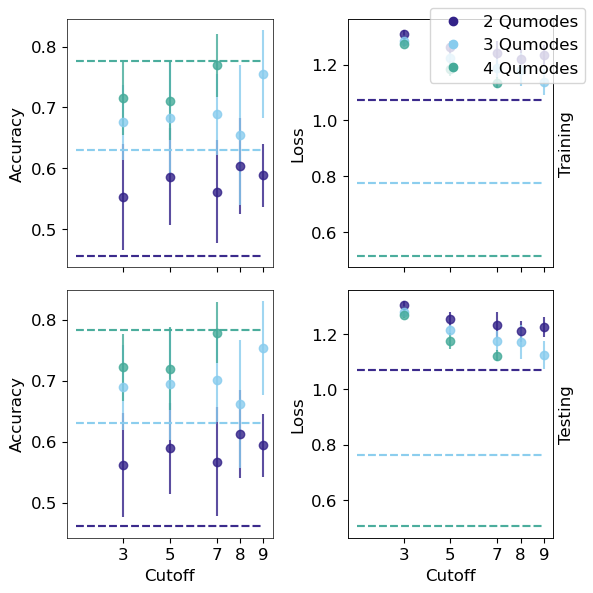

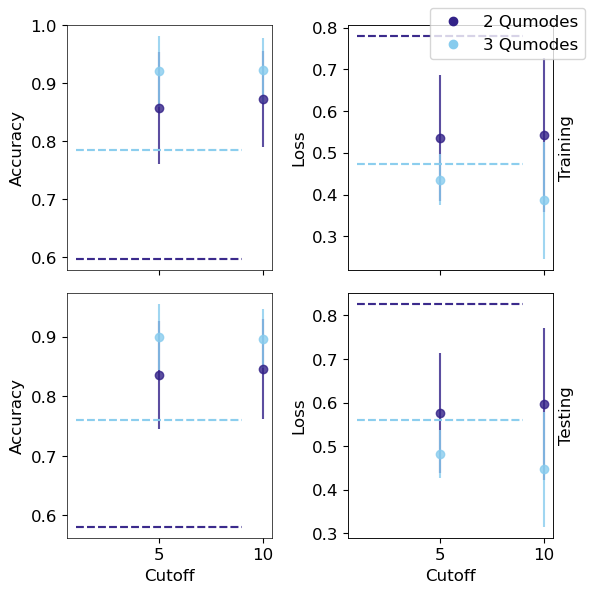

In [297]:
def plot_cutoff_sweep(df, fname='cutoff_sweep'):    
    df_cutoff = df[df['network_type']=='quantum'].groupby(['cutoff', 'num_qumodes']).apply(np.mean)
    df_cutoff['cutoff'] = df_cutoff['cutoff'].apply(int)
    df_classical = df[df['network_type']=='classical'].groupby(['cutoff', 'num_qumodes']).apply(np.mean)
    display(df_cutoff.head())
    display(df_classical.head())

    color_dict = dict(zip(df['num_qumodes'].unique(), colors))
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6,6), sharex=True)
    axs[0,0].set_ylabel('Accuracy')
    axs[1,0].set_ylabel('Accuracy')
    axs[0,1].set_ylabel('Loss')
    axs[1,1].set_ylabel('Loss')

    axs[1,0].set_xlabel('Cutoff')
    axs[1,1].set_xlabel('Cutoff')

    axs[0,0].set_xticks(df_cutoff['cutoff'].unique(), df_cutoff['cutoff'].unique())
    axs_dict = dict(zip(['acc', 'loss', 'val_acc', 'val_loss'], axs.flatten()))
    for i, row in df_cutoff.iterrows():
        for metric in ['acc', 'loss', 'val_acc', 'val_loss']:
            axs_dict[metric].errorbar(row['cutoff'], row[metric], yerr=row[f'{metric}_std'], fmt='o', color=color_dict[row['num_qumodes']], alpha=0.8)

    for i, row in df_classical.iterrows():
        for metric in ['acc', 'loss', 'val_acc', 'val_loss']:
            axs_dict[metric].hlines([row[metric], row[metric]], 1, 9, ls='--', color=color_dict[row['num_qumodes']], alpha=0.8)

    for key,val in color_dict.items():
        plt.plot([], [], marker='o', lw=0 , color=val, label=f'{key} Qumodes')

    ax2  = axs[0,1].twinx()
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    ax2.set_ylabel(f'Training') 

    ax2  = axs[1,1].twinx()
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    ax2.set_ylabel(f'Testing')   

    fig.legend()
    fig.tight_layout()

plot_cutoff_sweep(df_o_mean, 'cutoff_sweep')
plot_cutoff_sweep(df_k_mean, 'cutoff_sweep_kerr')

# Generate timing plots

,cutoff,n_layers,network_type,num_qumodes,time
49,8,3,quantum,3,29.434219
181,1,1,quantum,2,4.069443
700,1,4,quantum,4,35.732792
363,0,3,classical,3,0.013893
242,5,4,quantum,3,30.103796


,cutoff,n_layers,num_qumodes,time
count,558.000000,558.000000,558.000000,558.000000
mean,3.539427,2.931900,2.903226,15.885501
std,3.240407,1.461297,0.826811,17.804718
min,0.000000,1.000000,2.000000,0.007966
25%,0.000000,2.000000,2.000000,0.011081
50%,3.000000,3.000000,3.000000,10.519551
75%,7.000000,4.000000,4.000000,23.889029
max,9.000000,5.000000,4.000000,104.721803


,n_layers,num_qumodes,cutoff,time
count,96.000000,96.000000,96.000000,96.000000
mean,2.989583,2.906250,4.354167,18.474746
std,1.417892,0.795754,3.168859,17.625072
min,1.000000,2.000000,0.000000,0.008571
25%,2.000000,2.000000,1.000000,6.640710
50%,3.000000,3.000000,5.000000,14.680156
75%,4.000000,4.000000,7.000000,25.449163
max,5.000000,4.000000,9.000000,101.984397


,cutoff,n_layers,network_type,num_qumodes,time
49,5,1,quantum,2,4.474238
181,0,2,classical,2,0.002547
242,0,2,classical,4,0.002853
52,10,1,quantum,3,20.026088
27,10,1,quantum,2,7.431744


,n_layers,num_qumodes,time
count,253.000000,253.000000,253.000000
mean,2.565217,2.774704,6.272804
std,1.315617,0.756344,9.554437
min,1.000000,2.000000,0.001641
25%,1.000000,2.000000,0.002629
50%,2.000000,3.000000,0.002980
75%,3.000000,3.000000,10.215891
max,5.000000,4.000000,49.405092


,n_layers,num_qumodes,cutoff,time
count,27.000000,27.000000,27.000000,27.000000
mean,2.555556,2.777778,3.333333,7.402053
std,1.310705,0.751068,4.160251,10.299950
min,1.000000,2.000000,0.000000,0.002528
25%,1.500000,2.000000,0.000000,0.002723
50%,2.000000,3.000000,0.000000,0.002836
75%,3.000000,3.000000,5.000000,12.308775
max,5.000000,4.000000,10.000000,33.832750


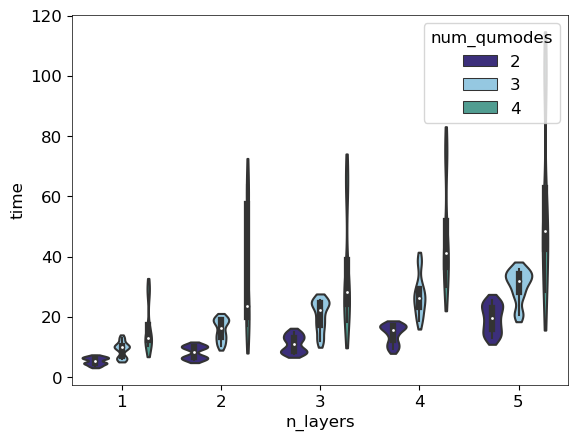

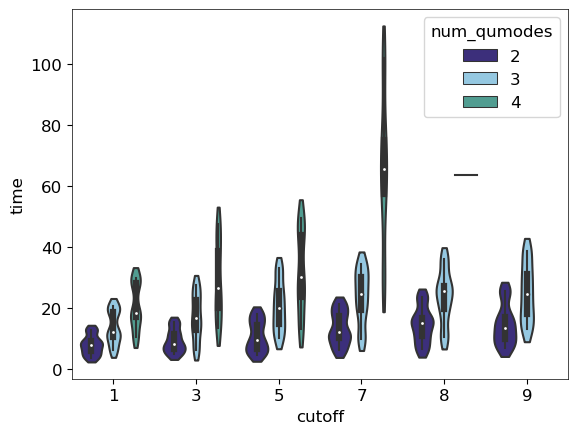

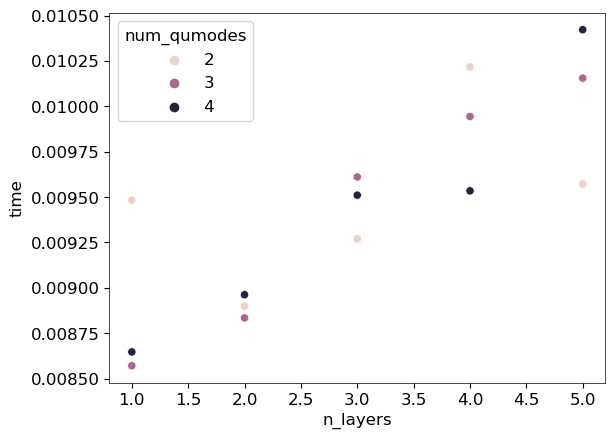

Correlation Matrix


,n_layers,num_qumodes,cutoff,time
n_layers,1.000000,-0.010204,-0.008541,0.368124
num_qumodes,-0.010204,1.000000,-0.157845,0.463521
cutoff,-0.008541,-0.157845,1.000000,0.439424
time,0.368124,0.463521,0.439424,1.000000


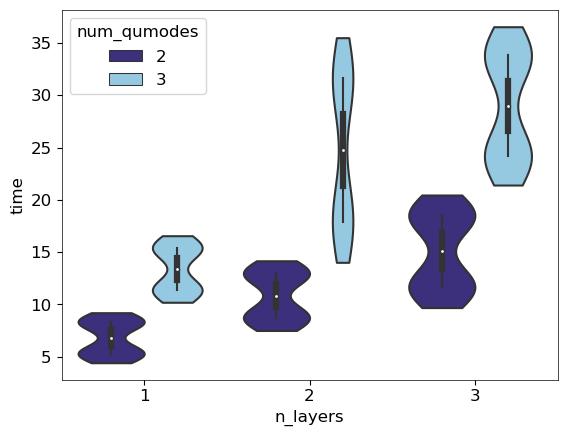

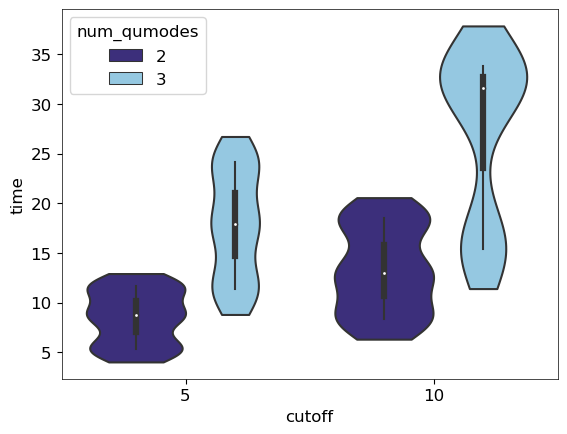

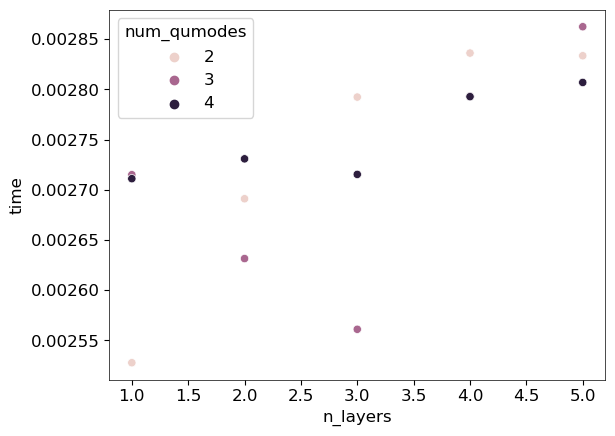

Correlation Matrix


,n_layers,num_qumodes,cutoff,time
n_layers,1.000000,0.130233,-0.352673,-0.180184
num_qumodes,0.130233,1.000000,-0.307729,-0.104796
cutoff,-0.352673,-0.307729,1.000000,0.840661
time,-0.180184,-0.104796,0.840661,1.000000


In [298]:
from common_packages.calc_time import calc_time, generate_time_database, calc_time_per_epoch, find_max_time
import seaborn as sns
def generate_time_df(ex_path):
    time_data = generate_time_database(ex_path) 
    df_time = pd.DataFrame(columns=time_data[1]['config'].keys())
    df_time['time'] = np.nan
    df_time.pop('__doc__')
    for exp, val in time_data.items():
        config = val['config']
        config.pop('__doc__', None)
        if config['iteration'] != -1:
            time = val['time']
            df_time.loc[exp] = [*config.values(), time] 
    df_time.pop('iteration')
    df_time.loc[df_time['network_type']=='classical', 'cutoff'] = 0
    df_time['time'] = df_time['time'] / np.timedelta64(1,'h')
    df_time_mean = df_time.groupby(['network_type', 'n_layers', 'num_qumodes', 'cutoff']).mean()
    df_time_mean.reset_index(inplace=True)
    display(df_time.head())
    # display(df_time_mean.head())
    display(df_time.describe())
    display(df_time_mean.describe())
    return df_time, df_time_mean

df_time_orig, df_time_mean_orig = generate_time_df('/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Experiment_cutoff_sweep')
df_time_kerr, df_time_mean_kerr = generate_time_df('/home/st4eve/Mounts/graham/synthetic_data/Synthetic_Quantum_Base_Kerr')

def plot_time_violin(df, fname='time_violin'):
    sns.violinplot(df[df['network_type']=='quantum'], x='n_layers', hue='num_qumodes', y='time', bw=0.4, cut=True)
    plt.show()
    sns.violinplot(df[df['network_type']=='quantum'], hue='num_qumodes', x='cutoff', y='time', bw=0.4, cut=True)
    plt.show()
    sns.scatterplot(df[df['network_type']=='classical'], hue='num_qumodes', x='n_layers', y='time')
    plt.show()
    print('Correlation Matrix')
    display(df.corr())

plot_time_violin(df_time_mean_orig, 'time_violin_orig')
plot_time_violin(df_time_mean_kerr, 'time_violin_kerr')



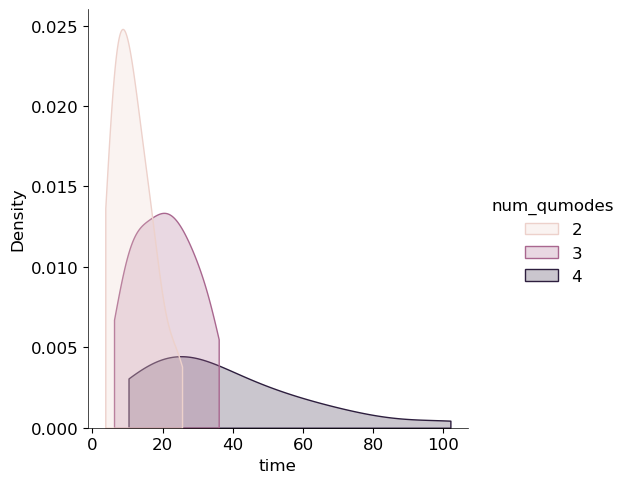

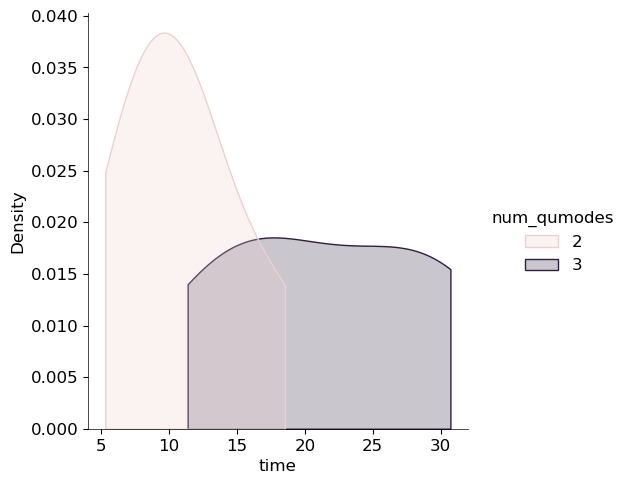

In [284]:
sns.displot(df_time_mean_orig[df_time_mean_orig['network_type']=='quantum'], x='time', hue='num_qumodes', kind='kde', cut=0, fill=True)
sns.displot(df_time_mean_kerr[df_time_mean_kerr['network_type']=='quantum'], x='time', hue='num_qumodes', kind='kde', cut=0, fill=True)

In [ ]:
ex_path = "Synthetic_Hybrid_Base_Experiment_Cutoff10"

dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[1]['config']
config.pop('__doc__', None)
#config.pop('iteration', None)
df = pd.DataFrame(columns=config.keys())
df['acc'] = np.nan
df['val_acc'] = np.nan
df['loss'] = np.nan
df['val_loss'] = np.nan
for i in data.keys():
    config = data[i]['config']
    config.pop('__doc__', None)
    metrics = data[i]['metrics']
    metrics.pop('epoch',None)
    acc, loss, val_acc, val_loss = metrics.values()
    acc = np.array(acc)
    loss = np.array(loss)
    val_acc = np.array(val_acc)
    val_loss = np.array(val_loss)
    df.loc[i] = [*config.values(), acc, val_acc, loss, val_loss]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(6.5, 5), sharey='row', sharex='col')
df.sort_values('network_type',inplace=True)
display(df[(df['network_type']=='classical') & (df['cutoff']==5)]['acc'])
num_qumodes = [2,3,4]
cutoff_dims = [5,10]
network_types = ['classical', 'quantum']

for i,qumodes in enumerate(num_qumodes):
    for j,cutoff in enumerate(cutoff_dims):
        for net_type in network_types:
            for n,row in df[(df['network_type']==net_type) & (df['cutoff']==cutoff) & (df['num_qumodes']==qumodes)].iterrows():
                print(net_type, qumodes, cutoff, (i,j))
                axs[i,j].plot(row['acc'])

plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
plt.legend()

In [ ]:

ex_path = "Synthetic_Hybrid_PWB_Experiment_Test2"
dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[6]['config']
config.pop('__doc__', None)
df = pd.DataFrame(columns=config.keys())
df['avg_acc'] = np.nan
df['acc_err'] = np.nan
df['avg_loss'] = np.nan
df['loss_err'] = np.nan
for i in range(1, len(data) + 1):
    try:
        config = data[i]['config']
        config.pop('__doc__', None)
        metrics = data[i]['metrics']
        metrics.pop('epoch',None)
        acc, loss = metrics.values()
        avg_acc = np.mean(acc)
        acc_err = np.std(acc)
        avg_loss = np.mean(loss)
        loss_err = np.std(loss)
        df.loc[i] = [*config.values(), avg_acc, acc_err, avg_loss, loss_err]
    except KeyError:
        print(f"Invalid: {i}")
   
x = np.array(df['sigma'].unique()).astype(float)
x = np.log2(1+1/x)
plot_df = pd.DataFrame(index=x)
df = df.sort_values('sigma')


In [ ]:
%matplotlib inline

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6, 5), sharex='col', sharey='row')


for i in range(2,5):


    mask = (df['network_type']=='quantum') & (df['num_qumodes']==i)

    x1 = np.array(df[mask]['sigma'].unique()).astype(float)
    x1 = np.log2(1+1/x1)

    acc_q = df[mask]['avg_acc']
    acc_err_q = df[mask]['acc_err']
    loss_q = df[mask]['avg_loss']
    loss_err_q = df[mask]['loss_err']

    mask = (df['network_type']=='classical') & (df['num_qumodes']==i)

    x2 = np.array(df[mask]['sigma'].unique()).astype(float)
    x2 = np.log2(1+1/x2)
    
    acc_c = df[mask]['avg_acc']
    acc_err_c = df[mask]['acc_err']
    loss_c = df[mask]['avg_loss']
    loss_err_c = df[mask]['loss_err']    

    #ax[i-2].grid(True, linestyle=':')
    line_q = ax[i-2].plot(x1, acc_q, alpha=0.8)
    ax[i-2].fill_between(x1, acc_q - acc_err_q, acc_q + acc_err_q, interpolate=True, alpha=0.2)
    
    line_c = ax[i-2].plot(x2, acc_c, alpha=0.8)
    ax[i-2].fill_between(x2, acc_c - acc_err_c, acc_c + acc_err_c, interpolate=True, alpha=0.2)
    ax[i-2].set_title(f'{i} Qumode')
    ax[i-2].hlines(0.9, 0, 10, linestyles='--', color=colors[6]) 
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.supylabel('Accuracy')
fig.supxlabel('Precision (Bits)')
fig.suptitle('Synthetic Data Accuracy Comparison')
plt.savefig(f'../Plotting/Synthetic_comparison.pdf')
plt.show()

In [ ]:
%matplotlib inline

for i in range(1, len(data) + 1):
    config = data[i]['config']
    config.pop('__doc__', None)
    metrics = data[i]['metrics']
    metrics.pop('epoch',None)
    acc, loss = metrics.values()
    avg_acc = np.mean(acc)
    acc_err = np.std(acc)
    avg_loss = np.mean(loss)
    loss_err = np.std(loss)
    df.loc[i] = [*config.values(), avg_acc, acc_err, avg_loss, loss_err]
   
    
df = df.sort_values('sigma')
x = np.array(df['sigma'].unique()).astype(float)
x = np.log2(1+1/x)
plot_df = pd.DataFrame(index=x)

mask = (df['network_type']=='quantum') & (df['num_qumodes']==4)
acc_q = df[mask]['avg_acc']
acc_err_q = df[mask]['acc_err']
loss_q = df[mask]['avg_loss']
loss_err_q = df[mask]['loss_err']

mask = (df['network_type']=='classical') & (df['num_qumodes']==4)

acc_c = df[mask]['avg_acc']
acc_err_c = df[mask]['acc_err']
loss_c = df[mask]['avg_loss']
loss_err_c = df[mask]['loss_err']

plot_df['Ph Q Acc 4'] = acc_q.values
plot_df['Ph Q Acc Err 4'] = acc_err_q.values
plot_df['Ph Q Loss 4'] = loss_q.values
plot_df['Ph Q Loss Err 4'] = loss_err_q.values
plot_df['Ph C Acc 4'] = acc_c.values
plot_df['Ph C Acc Err 4'] = acc_err_c.values
plot_df['Ph C Loss 4'] = loss_c.values
plot_df['Ph C Loss Err 4'] = loss_err_c.values

Plot = MultiPlot([x,x], 
                 [acc_q, acc_c],
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=['Quantum', 'Classical'], 
                 yerr=[acc_err_q, acc_err_c],
                 title='All Photonic 4 Qumode',
                 legend_position_x=0.5,
                 legend_position_y=-0.02)
Plot.options["figure_size_x"] = 8
Plot.options["figure_size_y"] = 4
Plot.plot()


In [ ]:
mask = (df['network_type']=='quantum') & (df['num_qumodes']==4)

acc_q = df[mask]['avg_acc']
acc_err_q = df[mask]['acc_err']
loss_q = df[mask]['avg_loss']
loss_err_q = df[mask]['loss_err']

mask = (df['network_type']=='classical') & (df['num_qumodes']==4)

acc_c = df[mask]['avg_acc']
acc_err_c = df[mask]['acc_err']
loss_c = df[mask]['avg_loss']
loss_err_c = df[mask]['loss_err']


plot_df['TF Q Acc 4'] = acc_q.values
plot_df['TF Q Acc Err 4'] = acc_err_q.values
plot_df['TF Q Loss 4'] = loss_q.values
plot_df['TF Q Loss Err 4'] = loss_err_q.values
plot_df['TF C Acc 4'] = acc_c.values
plot_df['TF C Acc Err 4'] = acc_err_c.values
plot_df['TF C Loss 4'] = loss_c.values
plot_df['TF C Loss Err 4'] = loss_err_c.values

Plot = MultiPlot([x,x], 
                 [acc_q, acc_c],
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=['Quantum', 'Classical'], 
                 yerr=[acc_err_q, acc_err_c],
                 title='Digital 4 Qumode',
                 legend_position_x=0.5,
                 legend_position_y=-0.02)
Plot.options["figure_size_x"] = 8
Plot.options["figure_size_y"] = 4
Plot.plot()

In [ ]:
mask = (df['network_type']=='quantum') & (df['num_qumodes']==3)

acc_q = df[mask]['avg_acc']
acc_err_q = df[mask]['acc_err']
loss_q = df[mask]['avg_loss']
loss_err_q = df[mask]['loss_err']

mask = (df['network_type']=='classical') & (df['num_qumodes']==3)

acc_c = df[mask]['avg_acc']
acc_err_c = df[mask]['acc_err']
loss_c = df[mask]['avg_loss']
loss_err_c = df[mask]['loss_err']

plot_df['Ph Q Acc 3'] = acc_q.values
plot_df['Ph Q Acc Err 3'] = acc_err_q.values
plot_df['Ph Q Loss 3'] = loss_q.values
plot_df['Ph Q Loss Err 3'] = loss_err_q.values
plot_df['Ph C Acc 3'] = acc_c.values
plot_df['Ph C Acc Err 3'] = acc_err_c.values
plot_df['Ph C Loss 3'] = loss_c.values
plot_df['Ph C Loss Err 3'] = loss_err_c.values

fig = plt.figure(
        figsize= (
                8,4))

Plot = MultiPlot([x,x], 
                 [acc_q, acc_c],
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=['Quantum', 'Classical'], 
                 yerr=[acc_err_q, acc_err_c],
                 title='All Photonic 3 Qumode',
                 legend_position_x=0.5,
                 legend_position_y=-0.02)
Plot.options["figure_size_x"] = 8
Plot.options["figure_size_y"] = 4
Plot.plot()

In [ ]:
names = ['Ph C Acc 4', 'Ph Q Acc 4']
names_err = [n.split(' ') for n in names]
[names_err[i].insert(-1, 'Err') for i,n in enumerate(names_err)]
names_err = [" ".join(names_err[i]) for i,n in enumerate(names_err)]

Plot = MultiPlot([plot_df.index for i in names], 
                 plot_df[names].values.T,
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=[*names], 
                 yerr=plot_df[names_err].values.T,
                 title='Network Comparison 4 Qumode',
                 legend_position_x=0.45,
                 legend_position_y=0.0)
Plot.options["figure_size_x"] = 8
Plot.options["figure_size_y"] = 4
Plot.plot()

In [ ]:
names = ['Ph C Acc 3', 'Ph Q Acc 3']
names_err = [n.split(' ') for n in names]
[names_err[i].insert(-1, 'Err') for i,n in enumerate(names_err)]
names_err = [" ".join(names_err[i]) for i,n in enumerate(names_err)]

Plot = MultiPlot([plot_df.index for i in names], 
                 plot_df[names].values.T,
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=[*names], 
                 yerr=plot_df[names_err].values.T,
                 title='Network Comparison 3 Qumode',
                 legend_position_x=0.6,
                 legend_position_y=0.0)
Plot.options["figure_size_x"] = 12
Plot.options["figure_size_y"] = 8
Plot.plot()

In [ ]:
%matplotlib inline
from common_packages.CV_quantum_layers import Activation_Layer, CV_Measurement, QuantumLayer_MultiQunode
from PWBLayer_TF import PWBLinearLayer
from keras import Model, layers, models, regularizers
from common_packages.utilities import get_equivalent_classical_layer_size
from hybrid_base import EXPERIMENT_NAME as BASE_EXPERIMENT_NAME
from hybrid_base import LOSS_FUNCTION, NUM_EPOCHS, OPTIMIZER, RANDOM_SEED
import tensorflow as tf
from data import generate_synthetic_dataset
import copy
import json
from os import listdir
from os.path import isdir, join
from hybrid_pwb import get_config
from sklearn.metrics import ConfusionMatrixDisplay

network_type = 'classical'
num_qumodes = 4

class Net(Model):  # pylint: disable=W0223
        """Neural network model to train on"""

        def __init__(self):
            self._estimator_type='classifier'
            super().__init__()
            precision = int(2**15 - 1)
            self.base_model = models.Sequential(
                [
                    layers.Dense(20, activation="relu"),
                    layers.Dense(20, activation="relu"),
                    layers.Dense(2*num_qumodes, activation=None),
                ]
            )

            if network_type == "classical":
                self.quantum_substitue = models.Sequential(
                    [
                        layers.Dense(
                            get_equivalent_classical_layer_size(num_qumodes, 2 * num_qumodes, 3),
                            activation="relu",
                            bias_constraint=lambda t: tf.clip_by_value(t, -1.0, 1.0),
                            kernel_constraint=lambda t: tf.clip_by_value(t, -1.0, 1.0),
                        ),
                    ]
                )

            self.quantum_layer = QuantumLayer_MultiQunode(
                n_qumodes=num_qumodes,
                n_circuits=1,
                n_layers=1,
                cutoff_dim=3,
                encoding_method="Amplitude_Phase",
                regularizer=regularizers.L1(l1=0.1),
                max_initial_weight=0.15,
                measurement_object=CV_Measurement("X_quadrature"),
                shots=None,
            )

            self.quantum_preparation_layer = Activation_Layer("Sigmoid", self.quantum_layer.encoding_object)

            self.final_layer = models.Sequential([layers.Dense(3, activation="softmax")])

        def call(self, inputs):  # pylint: disable=W0221
            """Call the network"""
            output = self.base_model(inputs)
            if network_type == "quantum":
                output = self.quantum_preparation_layer(output)
                output = self.quantum_layer(output)
            elif network_type == "classical":
                output = self.quantum_substitue(output)
            else:
                raise ValueError("Invalid network type specified.")
            output = self.final_layer(output)
            output = tf.argmax(output, axis=1)
            return output

_, validate_data = generate_synthetic_dataset()
model = Net()
model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=["accuracy"])
sub_folders = [folder for folder in listdir(BASE_EXPERIMENT_NAME) if isdir(join(BASE_EXPERIMENT_NAME, folder))]
experiment_numbers = [sub_folder for sub_folder in sub_folders if sub_folder.isdigit()]
target_experiment_path_list = []
predictions = []
for experiment_num in experiment_numbers:
    config = get_config(f"{BASE_EXPERIMENT_NAME}/{experiment_num}")
    if config["num_qumodes"] == num_qumodes and config["network_type"] == network_type:
        target_experiment_path_list.append(f"{BASE_EXPERIMENT_NAME}/{experiment_num}")

target_experiment_path = target_experiment_path_list[0]
model.load_weights(f"{target_experiment_path}/weights/weight{NUM_EPOCHS-1}.ckpt", by_name=False)

x = validate_data[0]
y = tf.argmax(validate_data[1], axis=-1)
fig = plt.figure(figsize=(1,1))
ConfusionMatrixDisplay.from_estimator(model, X=x, y=y)
plt.savefig('Synthetic_Confusion.pdf')
plt.show()

In [301]:
from quantum_base import *
from data import generate_synthetic_dataset
test_data, validate_data = generate_synthetic_dataset()

model = quantum_base

model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=["accuracy"])

NameError: name 'Net' is not defined